# Heart Attack Analysis

In this notebook there is comparison of 3 different models used for classification task. All classifications use heart attack dataset.

In [75]:
!pip install pandas
!pip install plotly
!pip install seaborn
!pip install sklearn
!pip install xgboost
!pip install imblearn

In [76]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from imblearn.over_sampling import RandomOverSampler

In [77]:
df = pd.read_csv('data/heart.csv')
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Data analysis

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [79]:
df.shape

(303, 14)

In [80]:
categorical_cols = ['exng', 'caa', 'cp', 'restecg']

px.imshow(df.drop(columns=categorical_cols).corr(numeric_only=True).round(2), text_auto=True, width=1000, height=1000, title='Correlation between variables', color_continuous_scale='Blues')

## One Hot encoding and transformations

In [81]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first')
df_tr = df.copy()

ohe.fit(df_tr[categorical_cols])
df_tr[ohe.get_feature_names_out(categorical_cols)] = ohe.transform(df_tr[categorical_cols])
df_tr.drop(columns=categorical_cols, inplace=True)
df_tr.head()

,age,sex,trtbps,chol,fbs,thalachh,oldpeak,slp,thall,output,exng_1,caa_1,caa_2,caa_3,caa_4,cp_1,cp_2,cp_3,restecg_1,restecg_2
0,63,1,145,233,1,150,2.3,0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,37,1,130,250,0,187,3.5,0,2,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,41,0,130,204,0,172,1.4,2,2,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,56,1,120,236,0,178,0.8,2,2,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,57,0,120,354,0,163,0.6,2,2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [82]:
X, y = df_tr.drop(columns=['output']), df_tr['output']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y, test_size=0.3)

print(f'Positive labels in train: {y_train.sum()}\nPositive labels in test: {y_test.sum()}')
print(f'Negative labels in train: {y_train.shape[0] - y_train.sum()}\nNegative labels in test: {y_test.shape[0] - y_test.sum()}')

ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(X_train, y_train)
print('\nAfter oversampling:')
print(f'Positive labels in train: {y_train.sum()}\nPositive labels in test: {y_test.sum()}')
print(f'Negative labels in train: {y_train.shape[0] - y_train.sum()}\nNegative labels in test: {y_test.shape[0] - y_test.sum()}')

sc = StandardScaler()
X_train[X_train.columns] = sc.fit_transform(X_train)
X_test[X_test.columns] = sc.transform(X_test)

Positive labels in train: 115
Positive labels in test: 50
Negative labels in train: 97
Negative labels in test: 41

After oversampling:
Positive labels in train: 115
Positive labels in test: 50
Negative labels in train: 115
Negative labels in test: 41


## Training

In [83]:
def run_training(model, run_cv: bool = False):
    if run_cv:
        print(f'CV mean accuracy: {cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy").mean()}')

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(conf_mat)
    cmd.plot()
    print(classification_report(y_test, y_pred))

CV mean accuracy: 0.8
              precision    recall  f1-score   support

           0       0.87      0.83      0.85        41
           1       0.87      0.90      0.88        50

    accuracy                           0.87        91
   macro avg       0.87      0.86      0.87        91
weighted avg       0.87      0.87      0.87        91



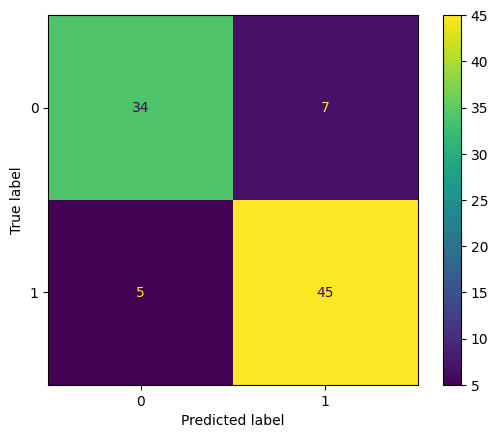

In [84]:
model1 = LogisticRegression(max_iter=1000, random_state=0)
run_training(model1, True)

CV mean accuracy: 0.7913043478260869
              precision    recall  f1-score   support

           0       0.74      0.83      0.78        41
           1       0.84      0.76      0.80        50

    accuracy                           0.79        91
   macro avg       0.79      0.79      0.79        91
weighted avg       0.80      0.79      0.79        91



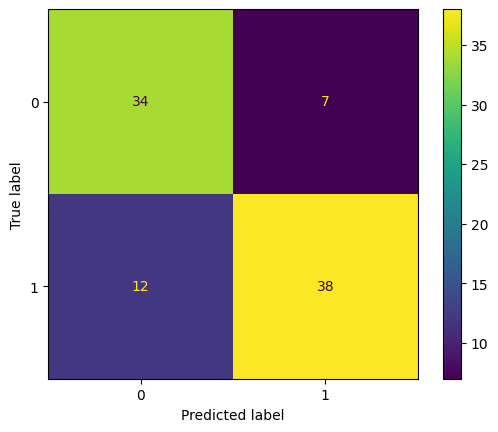

In [85]:
model2 = RandomForestClassifier(random_state=0)
run_training(model2, True)

CV mean accuracy: 0.7434782608695651
              precision    recall  f1-score   support

           0       0.67      0.73      0.70        41
           1       0.76      0.70      0.73        50

    accuracy                           0.71        91
   macro avg       0.71      0.72      0.71        91
weighted avg       0.72      0.71      0.71        91



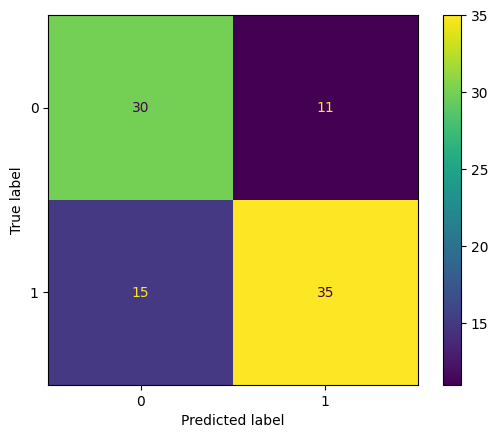

In [86]:
model3 = XGBClassifier()
run_training(model3, True)

## Conclusion
All methods have similar results. All results are strongly dependent on dataset splits because of the size of the dataset.
Logistic Regression performs better than other methods on the presented split.